In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn import svm
from sklearn import metrics

In [3]:
def linear_kernel(x1, x2):
  return x1.T @ x2

def poly_kernel(x1, x2, d = 2):
  #return (1 + np.dot(x1, x2)) ** d
  return (1 + x1 @ x2.T) ** d


In [4]:
class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self._eps = 0.001
        
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel == 'poly':
            self._k = poly_kernel
    
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b 
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b
        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        elif eta < 0:
          #Lobj = objective function at a2=L
          #Hobj = objective function at a2=H
          #if (Lobj < Hobj-eps):
            #a2 = L
          #else if (Lobj > Hobj+eps):
            #a2 = H
          #else:
            #a2 = alpha2
            b = self._b
            L1 = alpha1 + s*(alpha2 - L)
            H1 = alpha1 + s*(alpha2 - H)

            f1 = y1 * (e1 + b) - alpha1 * self._k(i1, i1) - s * alpha2 * self._k(i1, i2)
            f2 = y2 * (e2 + b) - alpha2 * self._k(i2, i2) - s * alpha1 * self._k(i1, i2)
            ol = (
                L1 * f1
                + L * f2
                + 1 / 2 * L1**2 * self._k(i1, i1)
                + 1 / 2 * L**2 * self._k(i2, i2)
                + s * L * L1 * self._k(i1, i2)
            )
            oh = (
                H1 * f1
                + H * f2
                + 1 / 2 * H1**2 * self._k(i1, i1)
                + 1 / 2 * H**2 * self._k(i2, i2)
                + s * H * H1 * self._k(i1, i2)
            )
            if ol < (oh - self._eps):
              a2 = L
            elif ol > oh + self._eps:
              a2 = H
            else:
              a2 = alpha2



        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        else:
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

In [5]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
X, y = make_circles(n_samples=150, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135, 2), (15, 2), (135,), (15,))

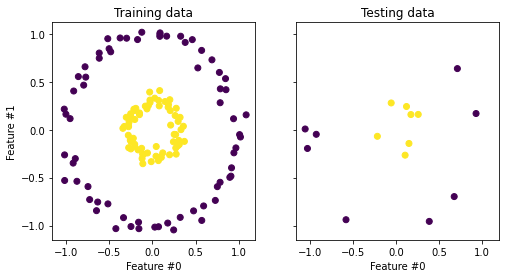

In [6]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [7]:
model = svm(c=1.0, kernel = 'poly')
model.fit(X_train, y_train)
print(model._weights)
print(model._b)

[0.03647515 0.33212398]
69.76106057415655


weights=[0.03647515 0.33212398]
b=69.76106057415655


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


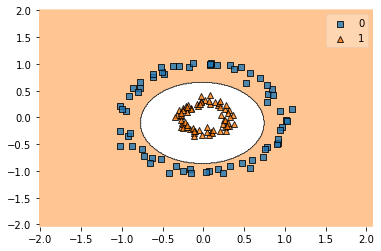

In [8]:
print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, model)
fig.add_subplot(ax)
plt.show()

In [9]:
y_prediction = model.predict(X_test)

In [10]:
print("Accuracy:",metrics.accuracy_score(y_test, y_prediction))

Accuracy: 0.0


In [11]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [12]:
model1 = svm(c=1.0, kernel = 'linear')
model1.fit(samples, targets)
print(model1._weights)
print(model1._b)

[ 0.50022787 -0.5795897 ]
-0.4931146122910508


weights=[ 0.50022787 -0.5795897 ]
b=-0.4931146122910508


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


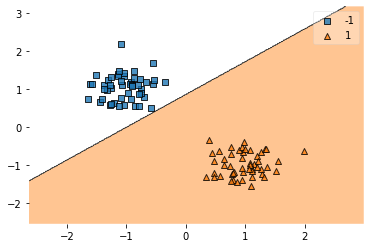

In [13]:
print(f"weights={model1._weights}")
print(f"b={model1._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int_), model1)
fig.add_subplot(ax)
plt.show()

Implement using sklearn

In [14]:
from sklearn import svm

#Creating svm Classifier
svm = svm.SVC(kernel='poly')

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
y_prediction = svm.predict(X_test)


In [15]:
#Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_prediction))

Accuracy: 0.5333333333333333


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


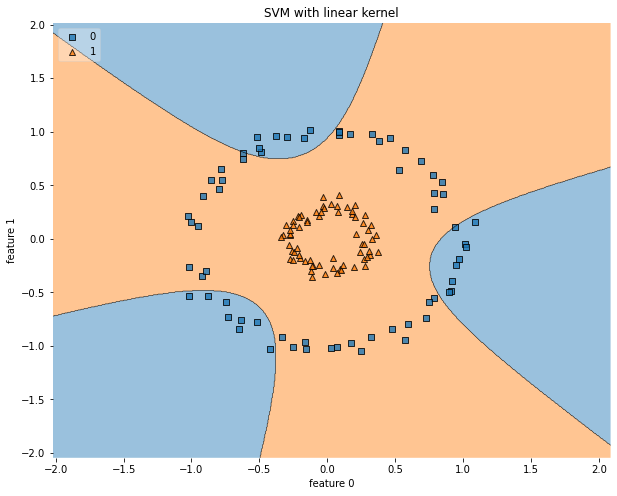

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plot_decision_regions(X_train, y_train, clf=svm, legend=2)
fig.add_subplot(ax)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.title('SVM with linear kernel')
plt.show()

In [17]:
from sklearn import svm
#Creating svm Classifier
svm1 = svm.SVC(kernel='linear')

#Train the model using the training sets
svm1.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm1.predict(X_test)

In [18]:
#Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4666666666666667


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


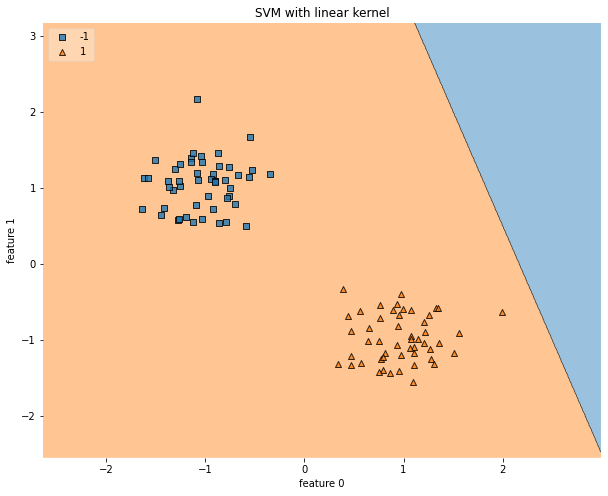

In [19]:
fig = plt.figure(figsize=(10,8))
ax = plot_decision_regions(samples, targets.astype(np.int_), clf=svm1, legend=2)
fig.add_subplot(ax)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.title('SVM with linear kernel')
plt.show()